In [2]:
### IMPORT AND CONFIGURATION/UTILITIES FUNCTION
import numpy as np
import torch
import random
from transformers import GPT2Tokenizer, GPT2Model
import matplotlib.pyplot as plt

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2Model.from_pretrained("gpt2", output_hidden_states=True, output_attentions=True, attn_implementation="eager")

## Geometry of the embedding space
How are the embedding tokens distributed in the 784-dimensional space? Let's perform some analysis to gain some insights on the geometric property of the embedding space

Formally speaking, the embedding space is essentially $\mathbb{R}^{784}$. Through the learning process, GPT-2 has decided how each token in the vocabulary should be represented, and thus we have a sequence of $V$ points $\{x_1, x_2, ..., x_v\} \subset \mathbb{R}^{784}$

We can study the norm (in the L2 sense) of those points

Total number of tokens in GPT-2: 50257
Mean of the embeddings norm: 3.9585


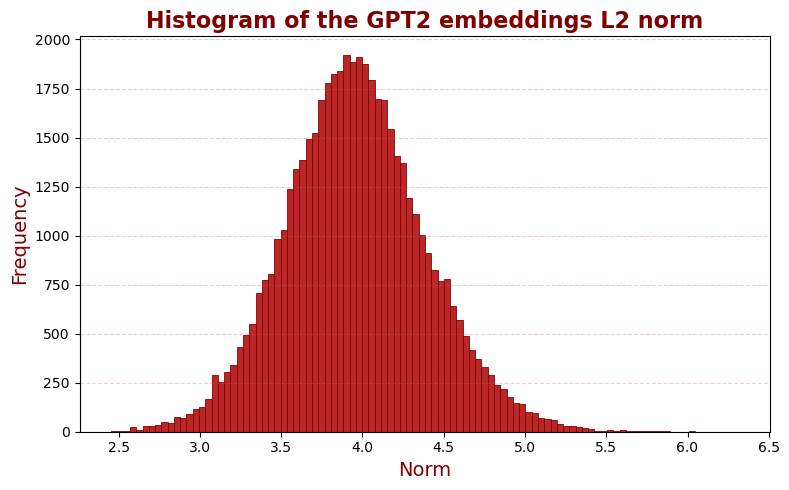

In [42]:
#### NORM OF THE EMBEDDINGS
embeddings_norm = torch.norm(model.wte.weight.data, dim=1)

# create a histogram of the embeddings norm


plt.figure(figsize=(8,5))

plt.hist(embeddings_norm.numpy(), bins=100,
         alpha=0.85,
         color='#B00000',       # Rosso principale
         edgecolor='#800000',   # Rosso più scuro per i bordi
         linewidth=0.7)

plt.title("Histogram of the GPT2 embeddings L2 norm",
          fontsize=16, weight='bold', color='#800000')
plt.xlabel("Norm", fontsize=14, color='#800000')
plt.ylabel("Frequency", fontsize=14, color='#800000')

plt.grid(axis='y', linestyle='--', alpha=0.3, color='#C06060')

plt.tight_layout()





print(f"Total number of tokens in GPT-2: {len(embeddings_norm)}")
print(f"Mean of the embeddings norm: {embeddings_norm.mean().item():.4f}")

plt.savefig('norms.svg', dpi=300, bbox_inches='tight')
plt.show()

They are not normalized to an unique value and their average value is about $4$. This means that they do not live in a hyper-sphere

Let's compute their average distance measured as their cosine similarity, i.e.:
$$
\cos_{ij} = \frac{x_i \cdot x_j}{||x_i||||x_j||}
$$
when $\cos_{i,j} = 0$, then the tokens are perpendicular, whereas if $\cos_{i,j} > 0$, then the angle between the tokens is acute

Average cosine similarity between tokens: 0.268


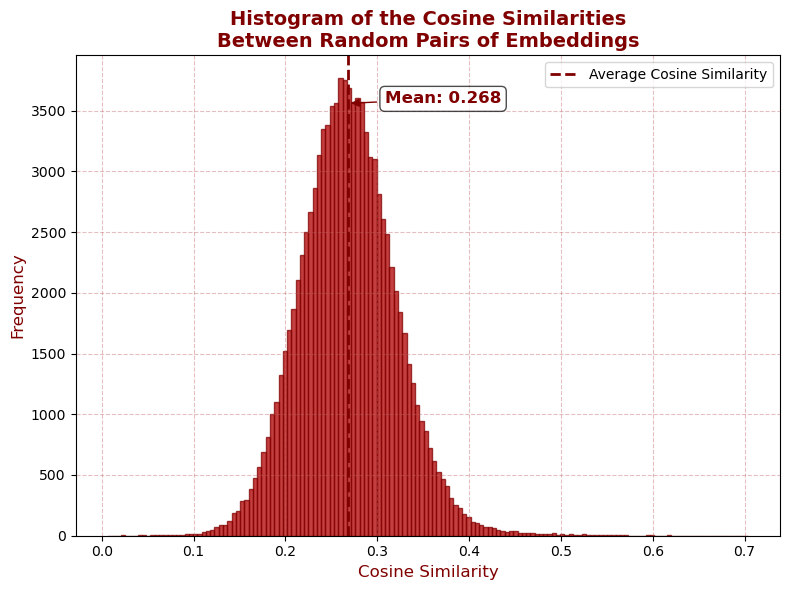

In [43]:
embeddings_normalized = model.wte.weight.data

rep = 100_000      # remember, there are 50257 tokens in GPT-2, so at max we can have 50257 * 50256 / 2 = 126_765_432 pairs of tokens
seen = set()
cosine_similarities = []
while len(cosine_similarities) < rep:
    i, j = sorted(random.sample(range(len(embeddings_normalized)), 2))
    if (i, j) in seen:
        continue
    seen.add((i, j))
    cos = torch.cosine_similarity(embeddings_normalized[i], embeddings_normalized[j], dim=0)
    cosine_similarities.append(cos.item())


plt.figure(figsize=(8, 6))

plt.hist(cosine_similarities, bins=150,
         color="#B00000",       # rosso università di Padova
         edgecolor="#800000",   # bordo rosso più scuro
         alpha=0.75)

plt.title("Histogram of the Cosine Similarities\nBetween Random Pairs of Embeddings",
          fontsize=14, fontweight='bold', color="#800000")

plt.xlabel("Cosine Similarity", fontsize=12, color="#800000")
plt.ylabel("Frequency", fontsize=12, color="#800000")

plt.grid(True, linestyle='--', alpha=0.4, color="#C06060")  # griglia rosso chiaro

plt.tight_layout()

# draw a vertical line at the average cosine similarity
mean_val = np.mean(cosine_similarities)
plt.axvline(mean_val, color='#800000', linestyle='--', linewidth=2, label='Average Cosine Similarity')

# Aggiungo annotazione accanto alla linea
plt.annotate(f'Mean: {mean_val:.3f}', 
             xy=(mean_val, plt.ylim()[1]*0.9), 
             xytext=(mean_val + 0.04, plt.ylim()[1]*0.9),
             color='#810000',
             fontsize=12,
             fontweight='bold',
             bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.7),
             arrowprops=dict(arrowstyle='-|>', color='#800000'))

plt.legend()


print(f"Average cosine similarity between tokens: {np.mean(cosine_similarities):.3f}")

plt.savefig('cosinesim.svg', dpi=300, bbox_inches='tight')
plt.show()

So on average, randomly sampled token are more probably acute than obtuse. This is somehow strange.

Let $x_i, x_j$ be two embedding vectors, corresponding to certain tokens. Then, if we sample the tokens were in an independent fashion, we'd expect that ($\langle \rangle$ is the sample average):
$$
\langle \cos_{i,j} \rangle = \langle x_i \cdot x_j \rangle \approx \langle x_i \rangle \cdot \langle x_j \rangle 
$$
If we assume that they are homogenously distributed around the origin, so that on average $\langle x_i \rangle = 0$, then we would have:
$$
\langle \cos_{i,j} \rangle = 0
$$
which clearly is not the case. So we must have assumed something that is not true


Let's compute the average token value

In [44]:
# average embedding token
mean_embeddings = torch.mean(model.wte.weight.data, dim = 0)
print("Average ratio between mean and a generic token", 100*torch.mean(mean_embeddings/model.wte.weight.data[3] ).item(), "\%")

mean_cosine_similarity = mean_embeddings @ mean_embeddings / (torch.mean(embeddings_norm) * torch.mean(embeddings_norm))
print("\nCosine similarity between the mean embedding and itself", mean_cosine_similarity.item())

Average ratio between mean and a generic token 143.15356016159058 \%

Cosine similarity between the mean embedding and itself 0.2687450349330902


So yes, the tokens have a specific average value different from zero (which is not small compared to the tokens itself, so it's not noise!). 

Furthermore, this average value can alone explain the measured average cosine simlarity between (i.e. the relation $\langle x_i x_j \rangle = \langle x_i \rangle \langle x_j \rangle$ seems to hold true)

Let's get rid of this mean value:

Average cosine similarity between tokens (removed mean): 0.26828


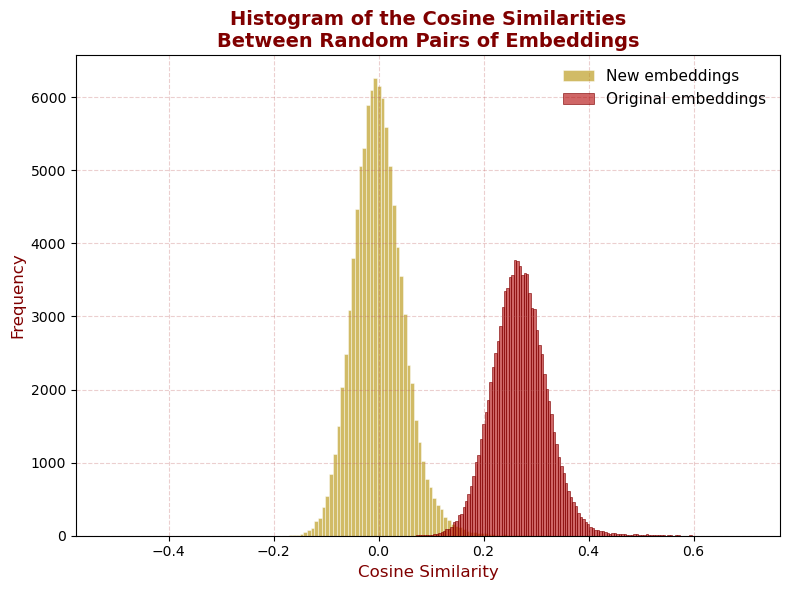

In [46]:
embeddings = model.wte.weight.data - mean_embeddings
rep = 100_000    # remember, there are 50257 tokens in GPT-2, so at max we can have 50257 * 50256 / 2 = 126_765_432 pairs of tokens

seen = set()
cosine_similarities_new = []
while len(cosine_similarities_new) < rep:
    i, j = sorted(random.sample(range(len(embeddings)), 2))
    if (i, j) in seen:
        continue
    seen.add((i, j))
    cos = torch.cosine_similarity(embeddings[i], embeddings[j], dim=0)
    cosine_similarities_new.append(cos.item())
fig, ax = plt.subplots(figsize=(8, 6))

# Istogramma "nuovo" (in oro spento)
ax.hist(cosine_similarities_new, bins=150, color='#B38F00', alpha=0.6,
        label='New embeddings', edgecolor='white', linewidth=0.5)

# Istogramma "originale" (in rosso Padova)
ax.hist(cosine_similarities, bins=150, color='#B00000', alpha=0.6,
        label='Original embeddings', edgecolor='#800000', linewidth=0.7)

# Titolo con colore coerente e font
ax.set_title("Histogram of the Cosine Similarities\nBetween Random Pairs of Embeddings",
             fontsize=14, fontweight='bold', color='#800000')

# Etichette assi in rosso scuro coerente
ax.set_xlabel("Cosine Similarity", fontsize=12, color='#800000')
ax.set_ylabel("Frequency", fontsize=12, color='#800000')

# Griglia con rosso chiaro
ax.grid(True, linestyle='--', alpha=0.3, color='#C06060')

# Legenda chiara senza bordo
ax.legend(frameon=False, fontsize=11)

plt.tight_layout()

print(f"Average cosine similarity between tokens (removed mean): {np.mean(cosine_similarities):.5f}")
plt.savefig('cosinesim2.svg', dpi=300, bbox_inches='tight')
plt.show()

And now, as expected, the distribution is centered around the origin. As a result, we obtained that GPT-2 has learnt a *bias* in the form of a constant vector in the embedding token
So the embedded points should look like:         


![             ](./draw.png)


Part of the initial norm is thus due to this non null center of mass. Let's compute again the distribution of the norm 

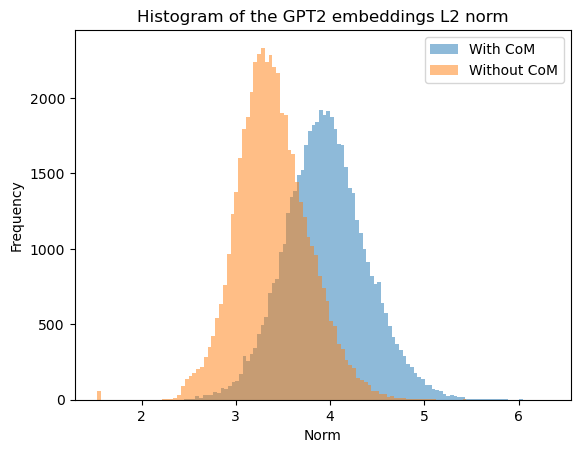

Mean of the embeddings norm w/ CoM: 3.9585
Mean of the embeddings norm w/o CoM: 3.3914


In [7]:
#### NORM OF THE EMBEDDINGS
embeddings_norm = torch.norm(model.wte.weight.data, dim=1)
embeddings_norm_nocdm = torch.norm(embeddings, dim=1)

# create a histogram of the embeddings norm
plt.hist(embeddings_norm.numpy(), bins=100, alpha = 0.5, label='With CoM')
plt.hist(embeddings_norm_nocdm.numpy(), bins=100, alpha=0.5, label='Without CoM')
plt.title("Histogram of the GPT2 embeddings L2 norm")
plt.xlabel("Norm")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# add a text with the total number of tokens
print(f"Mean of the embeddings norm w/ CoM: {embeddings_norm.mean().item():.4f}")
print(f"Mean of the embeddings norm w/o CoM: {embeddings_norm_nocdm.mean().item():.4f}")

And clearly enough, the average norm is now smaller. Basically this suggests us that, when susbtracting the center of mass, tokens are approximately distributed in multiple hyper-spheres, ranging from a radius of about 2 up to about 4


The norm of the center of mass is a good indicator of this asymmetry:

In [8]:
asimmetry = torch.norm(mean_embeddings)
print(f"Norm of the mean embedding: {asimmetry.item()}")
print(f"Average token norm: {torch.mean(embeddings_norm).item()}")
print(f"Thus it's not just noise")
print(f"Indeed, if we sum the norm of the center of mass with the average token norm w/o the center of mass, we get the original average norm: {np.sqrt(asimmetry.item()**2 + torch.mean(embeddings_norm_nocdm).item()**2)}")

Norm of the mean embedding: 2.052130937576294
Average token norm: 3.9585366249084473
Thus it's not just noise
Indeed, if we sum the norm of the center of mass with the average token norm w/o the center of mass, we get the original average norm: 3.963900978977242


To be completely sure, let's select one of the components of every token. Specifically, we look for the dimension $j$ such that the $j$-th component of the center of mass is the largest. This means that we are looking for a dimension in which the degree of asymmetry is the highest

Maximum dimension of the mean embedding: 64
Minimum dimension of the mean embedding: 72


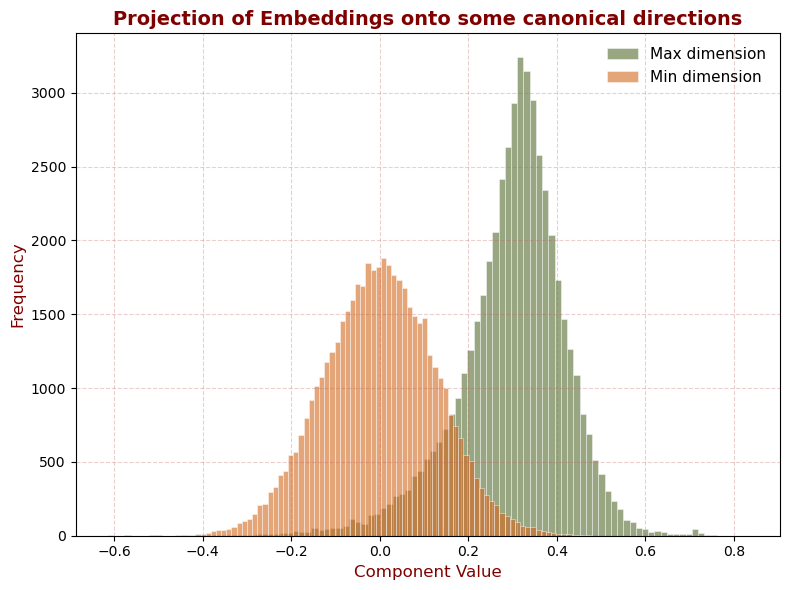

In [48]:
max_dimension = np.argmax(mean_embeddings)
min_dimension = np.argmin(np.abs(mean_embeddings))
print(f"Maximum dimension of the mean embedding: {max_dimension}")
print(f"Minimum dimension of the mean embedding: {min_dimension}")

components = model.wte.weight.data[:,max_dimension]
components_min = model.wte.weight.data[:,min_dimension]


plt.figure(figsize=(8, 6))

# Istogramma "Max dimension" — verde oliva scuro
plt.hist(components.numpy(), bins=100, alpha=0.6,
         color='#556B2F', edgecolor='white', linewidth=0.5)

# Istogramma "Min dimension" — arancione rame
plt.hist(components_min.numpy(), bins=100, alpha=0.6,
         color='#D2691E', edgecolor='white', linewidth=0.5)

# Titolo e label in rosso scuro
plt.title("Projection of Embeddings onto some canonical directions",
          fontsize=14, fontweight='bold', color='#800000')
plt.xlabel("Component Value", fontsize=12, color='#800000')
plt.ylabel("Frequency", fontsize=12, color='#800000')

# Griglia leggera
plt.grid(True, linestyle='--', alpha=0.3, color='#C06060')

# Legenda
plt.legend(['Max dimension', 'Min dimension'], fontsize=11, frameon=False)

# Layout ordinato
plt.tight_layout()

plt.savefig('asymmetry.svg', dpi=300, bbox_inches='tight')
plt.show()

![](./draw2.png)

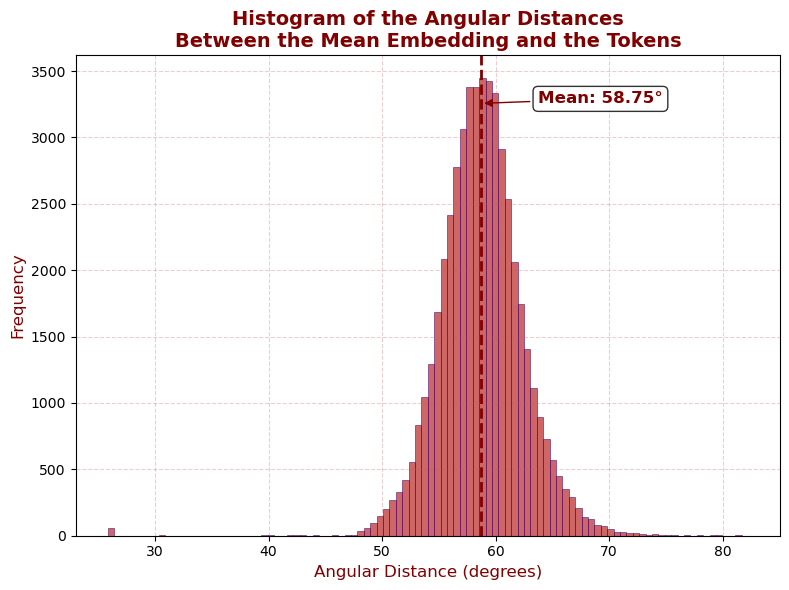

In [50]:
angularDistances = torch.cosine_similarity(model.wte.weight.data, mean_embeddings, dim=1).detach().numpy()

# Calcolo l'angolo in gradi
angular_degrees = np.arccos(angularDistances) * 180 / np.pi
mean_angle = np.mean(angular_degrees)

plt.figure(figsize=(8, 6))

# Istogramma rosso Padova
plt.hist(angular_degrees, bins=100,
         alpha=0.6, color='#B00000', edgecolor='#3F0071', linewidth=0.6)

# Linea verticale sulla media
plt.axvline(mean_angle, color='#800000', linestyle='--', linewidth=2)

# Annotazione con freccia
plt.annotate(f'Mean: {mean_angle:.2f}°',
             xy=(mean_angle, plt.ylim()[1]*0.9),
             xytext=(mean_angle + 5, plt.ylim()[1]*0.9),
             fontsize=12, fontweight='bold', color='#800000',
             bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.8),
             arrowprops=dict(arrowstyle='-|>', color='#800000'))

# Titolo e label coerenti
plt.title("Histogram of the Angular Distances\nBetween the Mean Embedding and the Tokens",
          fontsize=14, fontweight='bold', color='#800000')
plt.xlabel("Angular Distance (degrees)", fontsize=12, color='#800000')
plt.ylabel("Frequency", fontsize=12, color='#800000')

# Griglia elegante
plt.grid(True, linestyle='--', alpha=0.3, color='#C06060')

plt.tight_layout()
plt.savefig('cone.svg', dpi=300, bbox_inches='tight')
plt.show()


---

Why do we have this average value? Is there a small bias? Does it represent something?

![](./POST-Pre.png)


GPT2 should be Pre-LN

The effect of the Layer Norm is, given $x$ a row in the prompt matrix,
$$
LN(x) = \frac{x-\mu}{\sigma} \cdot \gamma + \beta
$$
where $\mu, \sigma$ are the average and standard dev along the row, so for each token. This means that, essentially,
$$
LN(x+ CoM) \neq LN(x)
$$

When entering the first layers of the transformers, this average value is automatically discarded due to the effect of the LayerNorm, which by design subtracts the mean of the tokens (still, this is not exactly true. Since we are summing the positional encoding, the effect of a center of mass is not negligible even within the first layernorm). Anyhow, in the last step of the transformer architecture, the last row of the token matrix gets converted to the vocabulary space by projecting it back with the transpose of the embedding matrix. This means that, in this last step, a bias in the tokens representation is significant, even though it was ignored when entering the first transformer step.

So we may ask ourselves why the algorithm has learnt this specific bias and whether or not it is meaningful. We can explore this issue my tweaking the E matrix that GPT2 uses to perform its computations and removing this bias

In [51]:
def get_tokens_prob(x, embedding, k = 5):
    # Compute the similarity between the token and all the tokens in the vocabulary, then applies softmax
    prob = torch.softmax(torch.matmul(x, (embedding).T), dim=-1)
    # Get the top k tokens
    top = torch.topk(prob, k=k)
    idxs = top.indices
    tokens = [tokenizer.decode(idx) for idx in idxs]
    return prob, top.values, idxs, tokens

# Functions that run the inference step and returns the PDF of the next token
def GPT2getPDF(prompt, lengthPrediction=5, verbose=False):
    inputs = tokenizer(prompt, return_tensors="pt")
    with torch.no_grad():
        # run the transfomer inference
        outputs = model(**inputs)
    lastMatrix = outputs.last_hidden_state[0]

    # the next token is the last one in the last layer
    nextToken = lastMatrix[-1, :] 
    #nextToken = model.ln_f(nextToken) # apply layer normalization
    
    # project it into the vocabulary space and build a pdf on top of it using softmax
    allProb, prob, idxs, tokens = get_tokens_prob(nextToken, model.wte.weight.data, lengthPrediction)
    if (verbose):
        for p, idx, token in zip(prob, idxs, tokens):
            print(f" -> logp = {-torch.log(p):.2f}: ['{token}'], idx = {idx}")
    return allProb

# Compare the usual GPT2 with a different version modifying the embedding matrix
def compareWithModified(prompt, func, lengthPrediction=5, verbose=False, funcPE = lambda x:x):
    initial_embedding = model.wte.weight.data
    initial_PE = model.wpe.weight.data
    if (verbose): print(" --> With the initial bias (normal GPT2):\n")
    probInitial = GPT2getPDF(prompt, lengthPrediction, verbose)
    model.wte.weight.data = func(model.wte.weight.data)
    model.wpe.weight.data = funcPE(model.wpe.weight.data)
    if (verbose): print("\n  --> With the modified version of E:\n")
    probFinal = GPT2getPDF(prompt, lengthPrediction, verbose)
    kl_div = torch.sum(probInitial * (torch.log(probInitial) - torch.log(probFinal)))
    hp = -torch.sum(probInitial * torch.log(probInitial))  # entropy of the initial distribution
    nmi = kl_div / hp  # normalized mutual information
    model.wte.weight.data = initial_embedding
    model.wpe.weight.data = initial_PE
    return kl_div, nmi

# generate a sentence starting from a prompt with zero temperature (acting on the embedding matrix)
def generateSentenceZeroTemp(startingPrompt, func = lambda x:x, length = 10, funcPE = lambda x:x):
    sentence = startingPrompt
    initial_embedding = model.wte.weight.data   # cache the initial GPT2 embedding matrix
    initial_PE = model.wpe.weight.data
    model.wte.weight.data = func(model.wte.weight.data)
    model.wpe.weight.data = funcPE(model.wpe.weight.data)
    for _ in range(length):  
        nextTokenIdx = torch.argmax(GPT2getPDF(sentence)).item()
        next_token = tokenizer.decode(nextTokenIdx)
        sentence += next_token
    model.wte.weight.data = initial_embedding  # restore the initial embedding matrix
    model.wpe.weight.data = initial_PE
    return sentence

Let us now see what happens in the GPT next token prediction if we modify the initial embedding matrix

In [113]:
prompt = "Astronomy is the study of celestial bodies and phenomena beyond Earth’s atmosphere. Using telescopes and spacecraft, scientists have discovered evidence for galaxies, black holes, and"
prompt = "The year is 2194, and humanity no longer lives on Earth. After the Collapse, we fled to floating arcologies orbiting the gas giants.\n" \
          "Every child knows the stories of our homeworld, but none of us have seen a tree, felt rain, or walked on"

KLDiv, NMI = compareWithModified(prompt, lambda v : v - torch.mean(v, dim = 0), 5, True, lambda v : v - torch.mean(v, dim = 0))
print(f"\nKL divergence between the two distributions: {KLDiv}, Normalized mutual info: {NMI}\n\n")

print("----------------------------------------------------------------")
KLDiv, NMI = compareWithModified(prompt, lambda v : torch.nn.functional.normalize(v, p=2, dim=1), 5, True)
print(f"\nKL divergence between the two distributions: {KLDiv},  Normalized mutual info: {NMI}\n\n")

 --> With the initial bias (normal GPT2):

 -> logp = 1.04: [' water'], idx = 1660
 -> logp = 1.58: [' a'], idx = 257
 -> logp = 2.16: [' the'], idx = 262
 -> logp = 3.64: [' ice'], idx = 4771
 -> logp = 3.72: [' fire'], idx = 2046

  --> With the modified version of E:

 -> logp = 1.14: [' water'], idx = 1660
 -> logp = 1.26: [' a'], idx = 257
 -> logp = 1.91: [' the'], idx = 262
 -> logp = 3.76: [' fire'], idx = 2046
 -> logp = 3.79: [' air'], idx = 1633

KL divergence between the two distributions: 0.07414311170578003, Normalized mutual info: 0.02532001957297325


----------------------------------------------------------------
 --> With the initial bias (normal GPT2):

 -> logp = 1.04: [' water'], idx = 1660
 -> logp = 1.58: [' a'], idx = 257
 -> logp = 2.16: [' the'], idx = 262
 -> logp = 3.64: [' ice'], idx = 4771
 -> logp = 3.72: [' fire'], idx = 2046

  --> With the modified version of E:

 -> logp = 5.73: ['theless'], idx = 9603
 -> logp = 6.14: ['soDeliveryDate'], idx = 39811

Let's now rotate the whole embedding matrix. We follow the procedure in https://math.stackexchange.com/questions/3698915/n-dimensional-rotation-matrix:


In [17]:
# Start by defining the identity matrix on R^784

def getRotationMatrixMonodim(dim):
    I = np.eye(model.wte.weight.data.shape[1])
    # we select a dimension and a vector, possibly normalized 
    vec = np.random.randn(model.wte.weight.data.shape[1])
    vec = vec / np.linalg.norm(vec)  # normalize the vector
    angles = vec @ I  # compute the angle between the vector and the selected dimension
    modified_I = I.copy()
    modified_I[:, [0, dim]] = modified_I[:, [dim, 0]]
    modified_I[:, 0] = vec
    #each column of I is a vector v1, v2, ..., v784
    # Now we need to perform Gran Schmidt orthonormalization on the columns of modified_I
    Q, _ = np.linalg.qr(modified_I)
    return torch.tensor(Q, dtype=torch.float32), angles

dim = 2
R, angle = getRotationMatrixMonodim(dim)    # rotation around the 42nd dimension
print(f"Rotated choosing dim.{dim}. Max angle {np.max(angle)*180/(np.pi):.3f} degrees, on average {np.mean(angle)*180/(np.pi):.3f} degrees")

prompt = "Astronomy is the study of celestial bodies and phenomena beyond Earth’s atmosphere. " \
"Using telescopes and spacecraft, scientists have discovered evidence for galaxies, black holes, and"

KLDiv, NMI = compareWithModified(prompt, lambda v : v @ R, 5, True)
print(f"\nKL divergence between the two distributions: {KLDiv}, Normalized mutual info: {NMI}\n\n")

KLDiv, NMI = compareWithModified(prompt, lambda v : (v - torch.mean(v, dim = 0)) @ R , 5, True, lambda v : v)
print(f"\nKL divergence between the two distributions: {KLDiv}, Normalized mutual info: {NMI}\n\n")

Rotated choosing dim.2. Max angle 8.458 degrees, on average 0.059 degrees
 --> With the initial bias (normal GPT2):

 -> logp = 1.52: [' other'], idx = 584
 -> logp = 3.13: [' even'], idx = 772
 -> logp = 3.16: [' dark'], idx = 3223
 -> logp = 3.20: [' planets'], idx = 14705
 -> logp = 3.37: [' super'], idx = 2208

  --> With the modified version of E:

 -> logp = 2.98: ['nels'], idx = 19423
 -> logp = 3.96: [''], idx = 214
 -> logp = 3.96: ['InstoreAndOnline'], idx = 40241
 -> logp = 4.02: ['�'], idx = 181
 -> logp = 4.03: ['embedreportprint'], idx = 30898

KL divergence between the two distributions: 20.220977783203125, Normalized mutual info: 4.304790496826172


 --> With the initial bias (normal GPT2):

 -> logp = 1.52: [' other'], idx = 584
 -> logp = 3.13: [' even'], idx = 772
 -> logp = 3.16: [' dark'], idx = 3223
 -> logp = 3.20: [' planets'], idx = 14705
 -> logp = 3.37: [' super'], idx = 2208

  --> With the modified version of E:

 -> logp = 2.23: ['nels'], idx = 19423
 -> 

---
So, somehow, the __average norm seems to have a specific meaning__, since its removal completely breaks the inference process. On the contrary, subtracting the center of mass has little overall effect.

Let's try to generate a sentence

In [11]:
prompt = "The year is 2194, and humanity no longer lives on Earth. After the Collapse, we fled to floating arcologies orbiting the gas giants.\n" \
          "Every child knows the stories of our homeworld, but none of us have seen a tree, felt rain, or walked on"

print(" ***** Without removing the mean:")
print(generateSentenceZeroTemp(prompt, lambda x:x, 20, lambda x:x))
print("\n ***** With the mean removed:")
print(generateSentenceZeroTemp(prompt, lambda x:x - torch.mean(x, dim = 0), 20, lambda x:x - torch.mean(x, dim = 0)))
print("-----------------------------------------------------------------------------------------")

prompt = "The sky turned a shade of green no one had ever seen before, and then the first tendrils of something unknown began to descend from the"

print(" ***** Without removing the mean:")
print(generateSentenceZeroTemp(prompt, lambda x:x, 20))
print("\n ***** With the mean removed:")
print(generateSentenceZeroTemp(prompt, lambda x:x - torch.mean(x, dim = 0), 20))

 ***** Without removing the mean:
The year is 2194, and humanity no longer lives on Earth. After the Collapse, we fled to floating arcologies orbiting the gas giants.
Every child knows the stories of our homeworld, but none of us have seen a tree, felt rain, or walked on water. We have no idea what life is like on Earth, and we are not alone.


 ***** With the mean removed:
The year is 2194, and humanity no longer lives on Earth. After the Collapse, we fled to floating arcologies orbiting the gas giants.
Every child knows the stories of our homeworld, but none of us have seen a tree, felt rain, or walked on water.
The world we live in is a place of darkness.
The world we live in
-----------------------------------------------------------------------------------------
 ***** Without removing the mean:
The sky turned a shade of green no one had ever seen before, and then the first tendrils of something unknown began to descend from the sky.


"What is it?"


"It's a meteorite," said

 **

In [40]:
prompt = "In literature, authors use narrative techniques such as symbolism, foreshadowing, and imagery to convey deeper meanings. " \
"Readers engage with these stories by interpreting characters and events that"
print(" ***** Without removing the mean:")
print(generateSentenceZeroTemp(prompt, lambda x:x, 8, lambda x:x))
print("\n ***** With the mean removed:")
print(generateSentenceZeroTemp(prompt, lambda x:x - torch.mean(x, dim = 0), 8, lambda x:x - torch.mean(x, dim = 0)))

 ***** Without removing the mean:
In literature, authors use narrative techniques such as symbolism, foreshadowing, and imagery to convey deeper meanings. Readers engage with these stories by interpreting characters and events that are not in the narrative.



 ***** With the mean removed:
In literature, authors use narrative techniques such as symbolism, foreshadowing, and imagery to convey deeper meanings. Readers engage with these stories by interpreting characters and events that are not in the real world.



In [41]:
prompt = "The expedition had been missing for months. When their last transmission was recovered, it contained only static, followed by a single whispered"
print(" ***** Without removing the mean:")
print(generateSentenceZeroTemp(prompt, lambda x:x, 30, lambda x:x))
print("\n ***** With the mean removed:")
print(generateSentenceZeroTemp(prompt, lambda x:x - torch.mean(x, dim = 0), 30, lambda x:x - torch.mean(x, dim = 0)))

 ***** Without removing the mean:
The expedition had been missing for months. When their last transmission was recovered, it contained only static, followed by a single whispered message.


"I'm sorry, but I'm not sure what you're talking about," the man said. "I'm not sure

 ***** With the mean removed:
The expedition had been missing for months. When their last transmission was recovered, it contained only static, followed by a single whispered message.


"I'm sorry, but I'm not sure what you're talking about. I'm not sure what you're talking about


It looks like removing the mean degrades the performances of the model (the model will just repeat part of the previous sentence --> Overfitting?)
How can we compare the two results? Both predictions seem reasonnable (but they are a bit different, anyway). Let's take a bunch of prompts and evaluate the KL divergence between the two proposed PDF

In [83]:
R, _ = getRotationMatrixMonodim(58)

KLDivsMean = list()
KLDivsNorm = list()

rotated_embedding = model.wte.weight.data @ R
with open("prompts.txt", "r") as file:
    for i,line in enumerate(file):
        prompt = line[:-1]
        KLDiv, NMI = compareWithModified(prompt, lambda v : v - torch.mean(v, dim = 0), 5, False)
        KLDivsMean.append(NMI)
        KLDiv, NMI = compareWithModified(prompt, lambda v : rotated_embedding, 5, False)
        KLDivsNorm.append(NMI)
        print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111


NameError: name 'KLDivsMean' is not defined

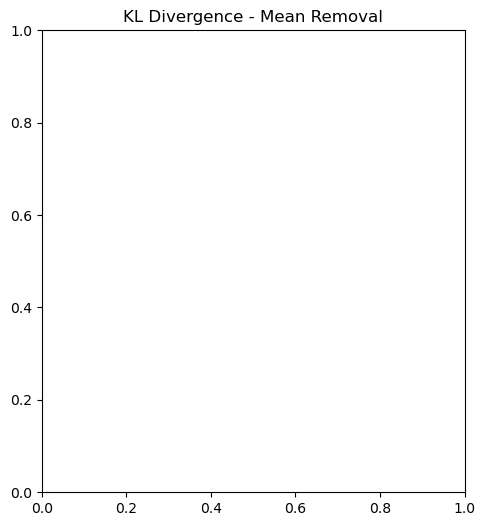

In [114]:
# plot the KL divergence values as histograms
# There should be two histograms, one for the mean removal and one for the normalization
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("KL Divergence - Mean Removal")
plt.hist(KLDivsMean, bins=100, range=(0,2), alpha=0.7, color='blue', edgecolor='black') 
plt.xlabel("KL/H")
plt.ylabel("Frequency")
plt.subplot(1, 2, 2)
plt.title("KL Divergence - Rotation")
plt.xlabel("KL/H")
plt.ylabel("Frequency")
plt.hist(KLDivsNorm, range = (0,2), bins=25, alpha=0.7, color='green', edgecolor='black')
plt.tight_layout()
plt.show()

print("Avg. KL div when removing the mean:", np.mean(KLDivsMean))
print("Avg. KL div when renormalizing upstream:", np.mean(KLDivsNorm))

How can we see if there is any kind of difference?

----

## Resolution of points

We randomly choose $rep$ points from the embedding space. To see how well separeted they are (how resolved are the semantic meaning, i.e.) we compute the cosine similarity with all the vocabulary and find the largest one, corresponding to the minimum angle that separates two different direction of meaning

In [52]:
import torch
import matplotlib.pyplot as plt

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
vocab = tokenizer.get_vocab()
model = GPT2Model.from_pretrained("gpt2", output_hidden_states=True, output_attentions=True, attn_implementation="eager")

rep = 1000
closest = np.zeros(rep)
for j in range(rep):
    token_idx = np.random.randint(0, model.wte.weight.data.shape[0] )
    token = model.wte.weight[token_idx]
    closeness = torch.cosine_similarity(token, model.wte.weight, dim=1)
    closeness[token_idx] = float('-inf')
    closest[j] = (torch.max(closeness).detach())

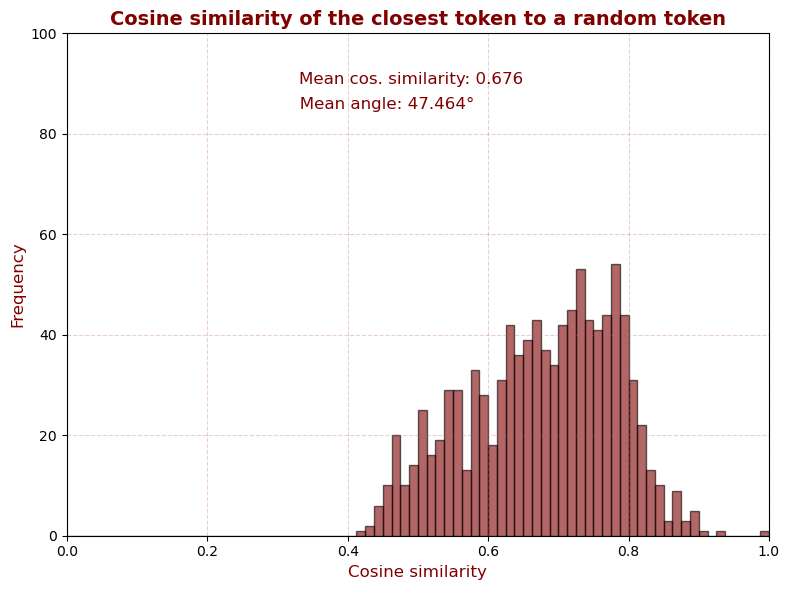

In [54]:

fig, ax = plt.subplots(figsize=(8, 6))

# Istogramma con colore rosso scuro, bordo nero, trasparenza 0.6
ax.hist(closest, bins=80, range=(0,1), color='#800000', edgecolor='black', alpha=0.6)

# Titolo e label con colore rosso scuro e font più leggibile
ax.set_title("Cosine similarity of the closest token to a random token", fontsize=14, fontweight='bold', color='#800000')
ax.set_xlabel("Cosine similarity", fontsize=12, color='#800000')
ax.set_ylabel("Frequency", fontsize=12, color='#800000')

# Limiti coerenti
ax.set_xlim(0, 1)
ax.set_ylim(0, 100)

# Griglia leggera rossa
ax.grid(True, linestyle='--', alpha=0.3, color='#C06060')

# Annotazioni con trasformazione in coordinate assi, colore rosso scuro, font dimensione 12
mean_cos = np.mean(closest)
mean_angle = (180/np.pi)*np.arccos(mean_cos)
ax.text(0.33, 0.9, f'Mean cos. similarity: {mean_cos:.3f}', transform=ax.transAxes, fontsize=12, color='#800000')
ax.text(0.1, 0.85, f'                               Mean angle: {mean_angle:.3f}°', transform=ax.transAxes, fontsize=12, color='#800000')

plt.savefig('closest.svg', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

This gives a hint about how well separated tokens are. The average angle is thus approximately $48 ^\circ$. This will be useful for later

---

## Positional encoding

In GPT2, the PE matrix is learnt, not deterministically set. Let's analyize a bit its structure

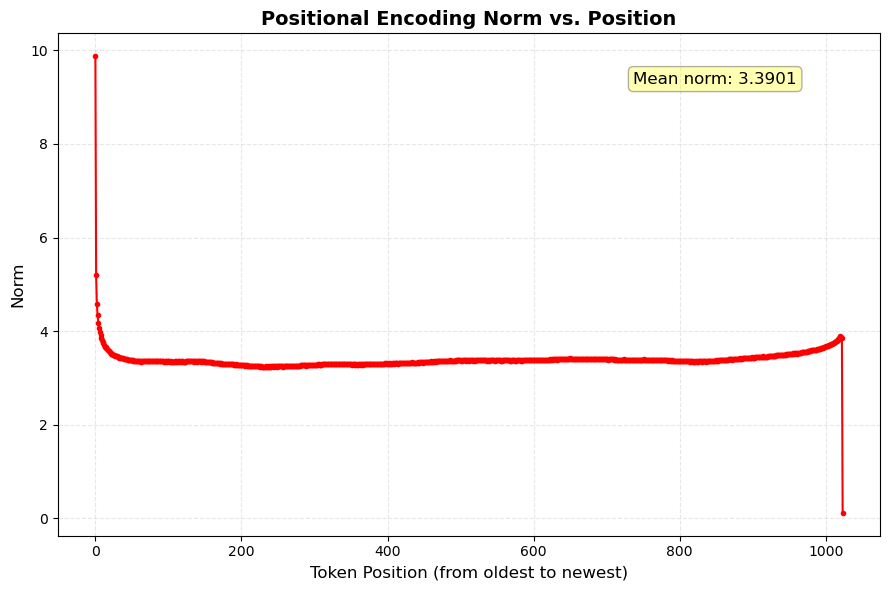

Total number of positional encodings in GPT-2: 1024
Mean of the embeddings norm vs. position: 3.3901


In [56]:
import torch
import matplotlib.pyplot as plt

PE = model.wpe.weight.data
PE_norm = torch.norm(PE, dim=1)

fig, ax2 = plt.subplots(figsize=(9, 6))



# Line plot norma L2 vs posizione token
ax2.plot(PE_norm.detach().numpy(), marker='o', linestyle='-', markersize=3, color='red')  # blu
ax2.set_title("Positional Encoding Norm vs. Position", fontsize=14, fontweight='bold')
ax2.set_xlabel("Token Position (from oldest to newest)", fontsize=12)
ax2.set_ylabel("Norm", fontsize=12)
ax2.grid(True, linestyle='--', alpha=0.3)

# Aggiungo annotation con la media sul secondo plot
mean_norm = PE_norm.mean().item()
ax2.annotate(f"Mean norm: {mean_norm:.4f}", xy=(0.7, 0.9), xycoords='axes fraction',
             fontsize=12, color='black', bbox=dict(boxstyle="round,pad=0.3", fc="yellow", alpha=0.3))

plt.tight_layout()
plt.savefig("PEnorm.svg")
plt.show()

print(f"Total number of positional encodings in GPT-2: {len(PE_norm)}")
print(f"Mean of the embeddings norm vs. position: {mean_norm:.4f}")


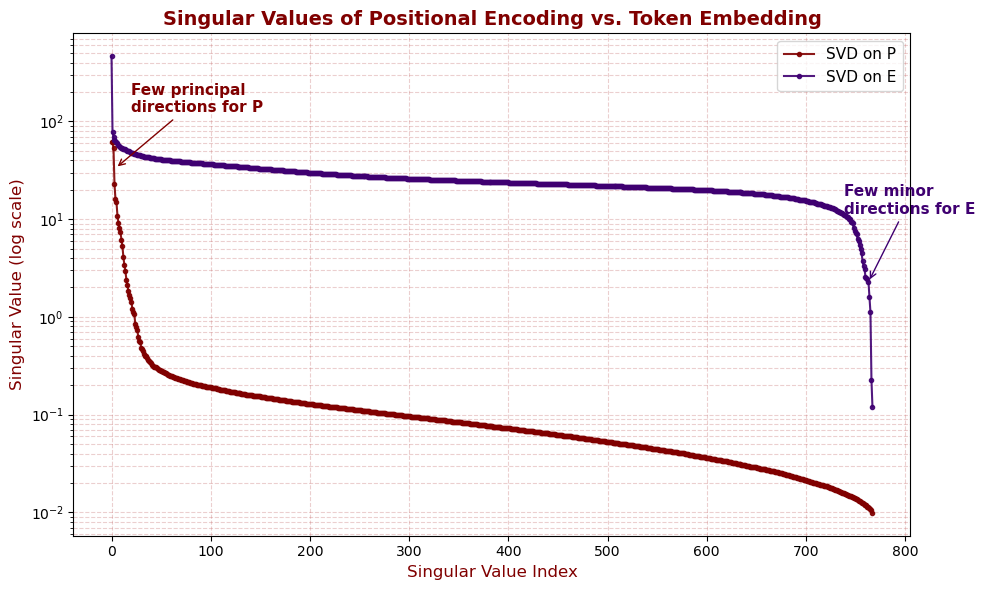

In [58]:
PE_np = PE.detach().cpu().numpy()  # PE è la positional embedding matrix

U, S, Vt = np.linalg.svd(PE_np, full_matrices=False)
U1, S1, Vt1 = np.linalg.svd(model.wte.weight.detach().cpu().numpy(), full_matrices=False)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Curve SVD
plt.semilogy(S, label='SVD on P',
             marker='o', linestyle='-', markersize=3,
             color='#800000', alpha=0.9)  # rosso scuro
plt.semilogy(S1, label='SVD on E',
             marker='o', linestyle='-', markersize=3,
             color='#3F0071', alpha=0.9)  # viola scuro

# Annotazioni testuali
plt.annotate('Few principal\ndirections for P',
             xy=(4, S[2]-20), xycoords='data',
             xytext=(20, S[0] * 2),
             textcoords='data',
             arrowprops=dict(arrowstyle='->', color='#800000'),
             fontsize=11, color='#800000', fontweight='bold')

plt.annotate('Few minor\ndirections for E',
             xy=(len(S1)-5, S1[-5]), xycoords='data',
             xytext=(len(S1)-30, S1[-5] * 5),
             textcoords='data',
             arrowprops=dict(arrowstyle='->', color='#3F0071'),
             fontsize=11, color='#3F0071', fontweight='bold')

# Titoli e label
plt.title("Singular Values of Positional Encoding vs. Token Embedding",
          fontsize=14, fontweight='bold', color='#800000')
plt.xlabel("Singular Value Index", fontsize=12, color='#800000')
plt.ylabel("Singular Value (log scale)", fontsize=12, color='#800000')

# Griglia e legenda
plt.grid(True, which='both', linestyle='--', alpha=0.3, color='#C06060')
plt.legend(fontsize=11)

plt.savefig('svd.svg', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()


/tmp/ipykernel_4628/3502860260.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.cosine_similarity(torch.tensor(first_principal_direction), torch.tensor(mean_embeddings), dim=0)


Shape of projections: torch.Size([768, 768])


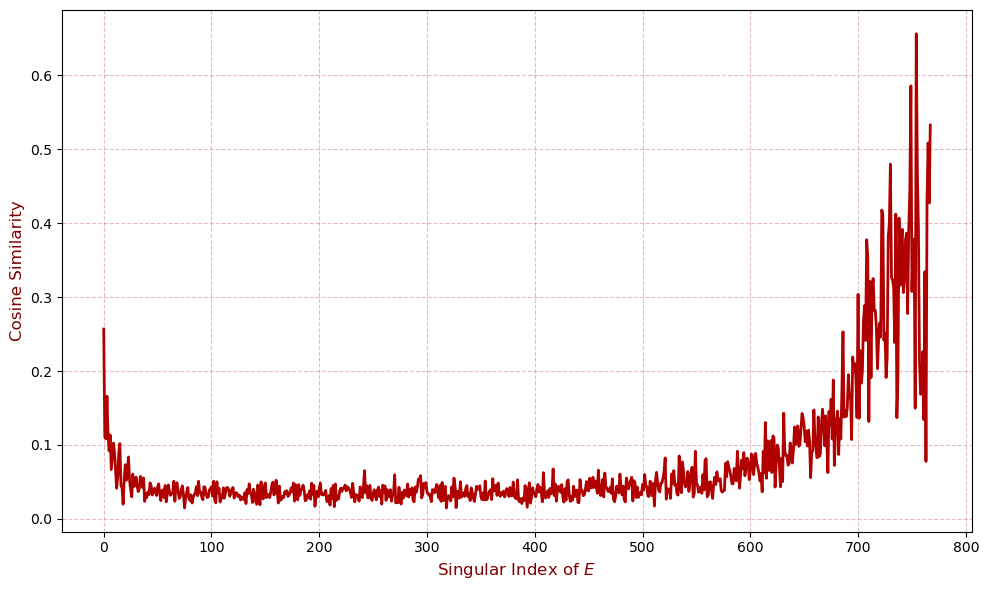

In [60]:
first_principal_direction = Vt1[0]

mean_embeddings = torch.mean(model.wte.weight.data, dim=0)
torch.cosine_similarity(torch.tensor(first_principal_direction), torch.tensor(mean_embeddings), dim=0)
# so, as expected, the first principal direction of the token embedding matrix is aligned with the mean embedding vector

# first_principal_directions: (10, d)
first_principal_directions = torch.tensor(Vt[:10], dtype=torch.float32)

# Ortonormalizziamo per sicurezza (anche se Vt dovrebbe esserlo già)
first_principal_directions = torch.nn.functional.normalize(first_principal_directions, dim=1)

# Trasponi per ottenere la matrice proiettore (d, 10)
projector = first_principal_directions.T  # shape: (d, 10)

# Vt1: (d, d) - ogni riga è una direzione singolare di B
Vt1_tensor = torch.tensor(Vt1, dtype=torch.float32)  # shape: (d, d)

# Calcolo proiezioni di ogni vettore di Vt1 nel sottospazio di projector
projections = []

for i in range(Vt1_tensor.shape[0]):
    vec = Vt1_tensor[i]  # shape: (d,)

    # Proiezione su base ortonormale: P = B B^T v
    # (10-dim coefficients)
    coeffs = projector.T @ vec          # shape: (10,)
    proj_vec = projector @ coeffs       # shape: (d,)

    projections.append(proj_vec)

projections = torch.stack(projections)  # shape: (d, d)
print(f"Shape of projections: {projections.shape}")

# (Opzionale) quantità di "energia" proiettata per ciascuna direzione:
projection_norms = torch.norm(projections, dim=1)
original_norms = torch.norm(Vt1_tensor, dim=1)
fractional_energy = projection_norms / original_norms  # shape: (d,)

plt.figure(figsize=(10, 6))
plt.plot(fractional_energy.numpy(), color='#B00000', linewidth=2)  # rosso scuro elegante

# Titoli e etichette
plt.xlabel("Singular Index of $E$", fontsize=12, color='#800000')
plt.ylabel("Cosine Similarity", fontsize=12, color='#800000')

# Griglia sottile
plt.grid(True, linestyle='--', alpha=0.4, color='#C06060')

plt.savefig('projection.svg', dpi=300, bbox_inches='tight')
# Margini e layout
plt.tight_layout()
plt.show()


Variance explained by first 3 components: 0.87728685


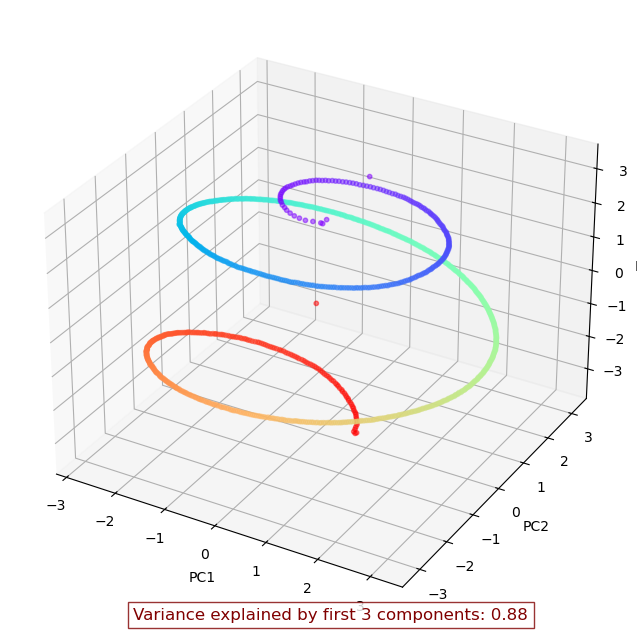

In [62]:
# Project the matrix P onto its 3 first principal directions
V3 = Vt.T[:, :3]

# Proiezione di PE lungo le prime 3 componenti principali
PE_proj = PE @ V3


explained_variance = S**2
total_variance = np.sum(explained_variance)
explained_variance_ratio = explained_variance / total_variance

# Varianza spiegata dalle prime 3 componenti
variance_explained_3 = np.sum(explained_variance_ratio[:3])
print("Variance explained by first 3 components:", variance_explained_3)

# plot in 3d
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
# annotate on the graph the variance explained by the first 3 components
ax.text2D(0.2, 0.01, f"Variance explained by first 3 components: {variance_explained_3:.2f}",
          transform=ax.transAxes, fontsize=12, color='#800000',
          bbox=dict(facecolor='white', alpha=0.8, edgecolor='#800000')) 
# color gradient not along the norm but according to the index
colors = plt.cm.rainbow(np.linspace(0, 1, PE_proj.shape[0]))
ax.scatter(PE_proj[:, 0].numpy(), PE_proj[:, 1].numpy(), PE_proj[:, 2].numpy(), c=colors, marker='o', alpha=0.5, s=10)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')


plt.savefig('PE_projection.svg', dpi=300, bbox_inches='tight')
plt.show()

The first positional token has a surprisingly high norm with respect to the others. The trend is bizzarre, it starts very high and then stabilize. The first tokens in the prompt are thus significantly perturbed! 

How much are tokens from the embedding space perturbed when adding the PE?

Norm of a token before PE at first position 3.3477866649627686
Norm of a token after PE at first position 10.443981170654297
Mean angle between tokens before and after PE[0]: 69.459°
Mean angle between tokens before and after PE[10]: 43.267°
Mean angle between tokens before and after PE[200]: 39.575°
Mean angle between tokens before and after PE[400]: 40.449°


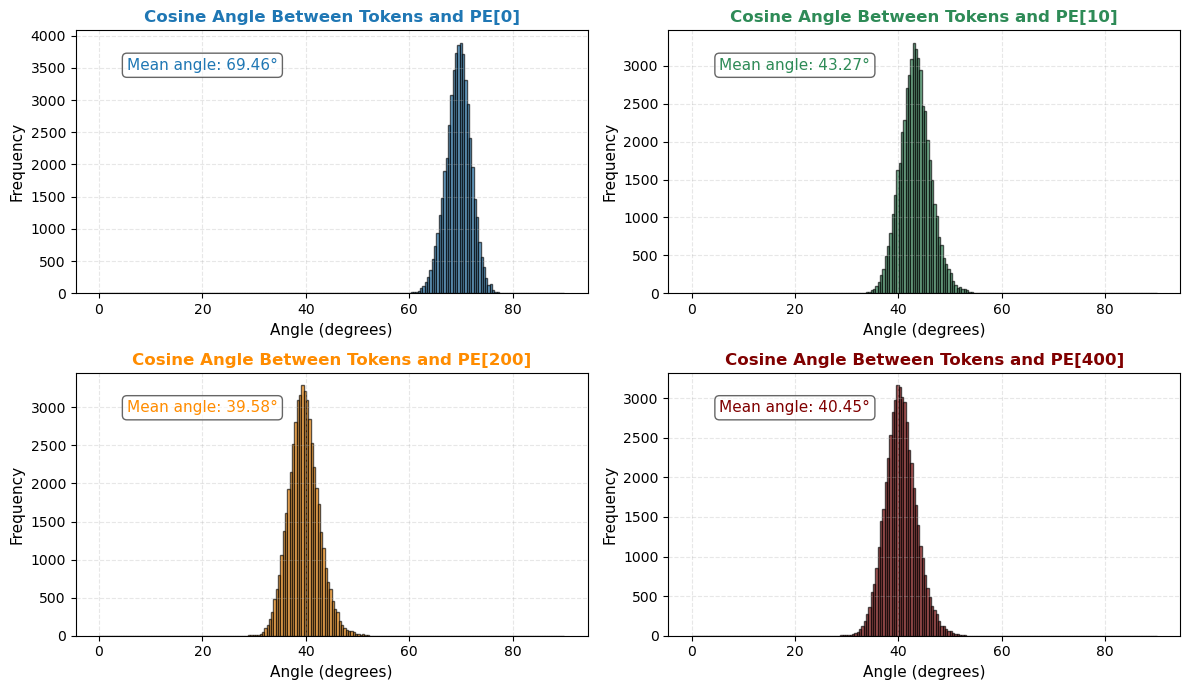

In [64]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import random

rep = 50_000
random_idces = random.sample(range(model.wte.weight.shape[0]), rep)
token = model.wte.weight.data[random_idces, :]

# Aggiunta della positional encoding
token_after_PE = [token + PE[pos] for pos in [0, 10, 200, 400]]
positions = [0, 10, 200, 400]
colors = ['#1F77B4', '#2E8B57', '#FF8C00', '#800000']  # blu, verde, arancione, rosso scuro

# Info di debug
print("Norm of a token before PE at first position", torch.norm(token[0]).item())
print("Norm of a token after PE at first position", torch.norm(token_after_PE[0][0]).item())

# Plot setup
fig, axs = plt.subplots(2, 2, figsize=(12, 7))
axs = axs.flatten()

for i, pos in enumerate(positions):
    angles_deg = (180 / np.pi) * np.arccos(
        torch.clamp(
            torch.cosine_similarity(token, token_after_PE[i], dim=1), -1.0, 1.0
        ).detach().numpy()
    )

    axs[i].hist(angles_deg, bins=200, range=(0, 90), color=colors[i], edgecolor='black', alpha=0.65)
    axs[i].set_title(f"Cosine Angle Between Tokens and PE[{pos}]", fontsize=12, fontweight='bold', color=colors[i])
    axs[i].set_xlabel("Angle (degrees)", fontsize=11)
    axs[i].set_ylabel("Frequency", fontsize=11)
    axs[i].grid(True, linestyle='--', alpha=0.3)

    mean_angle = np.mean(angles_deg)
    axs[i].annotate(f"Mean angle: {mean_angle:.2f}°", xy=(0.1, 0.85), xycoords='axes fraction',
                    fontsize=11, bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.6), color=colors[i])

plt.tight_layout()

# Stampa valori medi
for i, pos in enumerate(positions):
    mean_angle = np.mean((180 / np.pi) * np.arccos(
        torch.clamp(torch.cosine_similarity(token, token_after_PE[i], dim=1), -1.0, 1.0).detach().numpy()
    ))
    print(f"Mean angle between tokens before and after PE[{pos}]: {mean_angle:.3f}°")

plt.savefig("comparison4.svg", dpi=300, bbox_inches='tight')
plt.show()


The angle here indicates by how much the direction is shifted by the positional encoding. The smaller this angle, the less influent the positional encoder was in changing its direction (which is actually good). For positions larger than approximately 10, the angular shift is smaller than the resolution that we computed above between different tokens, so it should not mess up with the embedding space itself. What is interesting is that the first word in the prompt are given an incredibily high importance and they are greatly perturbed by the adding of the PE

In [97]:
word = "The"
word_idx = tokenizer.encode(word)[0]
word_embedding = model.wte.weight.data[word_idx]

allProb, prob, idxs, tokens = get_tokens_prob(word_embedding, model.wte.weight.data, 5)
for p, idx, token in zip(prob, idxs, tokens):
    print(f" -> logp = {-torch.log(p):.2f}: ['{token}'], idx = {idx}")
print(f"\nNow adding the positional encoding vector at position 0 to the word '{word}' embedding\n")
word_embedding_after_PE = word_embedding + PE[0]  # adding the positional encoding vector at position 0

allProb_PE, prob_PE, idxs_PE, tokens_PE = get_tokens_prob(word_embedding_after_PE, model.wte.weight.data, 5)
for p, idx, token in zip(prob_PE, idxs_PE, tokens_PE):
    print(f" -> logp = {-torch.log(p):.2f}: ['{token}'], idx = {idx}")

print("\nNow \"The\" has been sent to a strange word that is very close to \"theless\". Strangely enough, this word shows up quite often when messing with GPT. Why?")
print(f"\nNorm of the token \"theless\": {torch.norm(model.wte.weight.data[9603]):.3f}")
print("The token \"theless\" is one of the most distant (with the highest norm). As we've seen before, the first positional vector greatly increases the norm of the corresponding token \n(up to norm 10). At those distances, the closest token is the one with highest norm, which in this case is \"theless\".")
ln1 = model.h[0].ln_1 
print(f"\nNote that the LayerNorm only reduces the vector by its average, not norm: {torch.norm(ln1(word_embedding_after_PE))}")

 -> logp = 6.09: ['The'], idx = 464
 -> logp = 7.50: ['ccording'], idx = 2941
 -> logp = 7.54: [' The'], idx = 383
 -> logp = 7.63: ['This'], idx = 1212
 -> logp = 7.68: ['It'], idx = 1026

Now adding the positional encoding vector at position 0 to the word 'The' embedding

 -> logp = 5.89: ['theless'], idx = 9603
 -> logp = 6.53: ['The'], idx = 464
 -> logp = 6.86: ['���'], idx = 47490
 -> logp = 7.02: ['▬'], idx = 47530
 -> logp = 7.07: ['ּ'], idx = 47903

Now "The" has been sent to a strange word that is very close to "theless". Strangely enough, this word shows up quite often when messing with GPT. Why?

Norm of the token "theless": 6.013
The token "theless" is one of the most distant (with the highest norm). As we've seen before, the first positional vector greatly increases the norm of the corresponding token 
(up to norm 10). At those distances, the closest token is the one with highest norm, which in this case is "theless".

Note that the LayerNorm only reduces the vector by it

Again, we can see if the PE has a certain center of mass by evaluating the norm of the average PE vector:

In [100]:
print("Norm of the average PE vector", torch.norm(torch.mean(PE, dim = 0)).item())

Norm of the average PE vector 0.5915879011154175


This is smaller than the norm of the average embedded token, but still not sufficiently close to 0

In [48]:
import seaborn as sns

cosine_similarities_only_buffer= []
cosine_similarities_with_PE = []
cosine_similarities_with_LN = []

norm_CM_before_PE = []
norm_CM_after_PE = []
norm_CM_after_ln = []

mean_norm_before_PE = []
mean_norm_after_PE = []
mean_norm_after_ln = []

# closest
angles_before_PE = []
angles_after_PE = []
angles_after_ln = []


with open("prompts.txt", "r") as file:
    for i,line in enumerate(file):
        if i > 120 : break
        prompt = line[:-1]
        inputs = tokenizer(prompt, return_tensors="pt")
        T = torch.nn.functional.one_hot(inputs.input_ids[0], num_classes=model.wte.weight.data.shape[0]).float()
        E = torch.matmul(T , model.wte.weight.data)
        buffer = E

        norm_CM_before_PE.append(torch.norm(torch.mean(buffer, dim = 0)).item())
        norm_CM_after_PE.append(torch.norm(torch.mean(buffer+PE[:len(buffer),:], dim = 0)).item())

        mean_norm_before_PE.append(torch.mean(torch.norm(buffer, dim = 1)).item())
        mean_norm_after_PE.append(torch.mean(torch.norm(buffer+PE[:len(buffer),:],dim=1)).item())

        buffer_after_ln = model.h[0].ln_1(buffer+PE[:len(buffer),:])

        norm_CM_after_ln.append(torch.norm(torch.mean(buffer_after_ln, dim = 0)).item())
        mean_norm_after_ln.append(torch.mean(torch.norm(buffer_after_ln, dim = 1)).item())

        for i in range(len(buffer)):
            for j in range(i+1, len(buffer)):
                cos = torch.cosine_similarity(buffer[i], buffer[j], dim=0)
                cosine_similarities_only_buffer.append(cos.item())
                cos = torch.cosine_similarity(buffer[i]+PE[i], buffer[j]+PE[j], dim=0)
                cosine_similarities_with_PE.append(cos.item())
                cos = torch.cosine_similarity(buffer_after_ln[i], buffer_after_ln[j], dim=0)
                cosine_similarities_with_LN.append(cos.item())


        mean_direction_before_PE = torch.mean(buffer, dim=0)
        mean_direction_after_PE = torch.mean(buffer + PE[:len(buffer),:], dim=0)
        mean_direction_after_ln = torch.mean(buffer_after_ln, dim = 0)

        for k in range(len(buffer)):
            token = buffer[k]
            angle = torch.cosine_similarity(token, mean_direction_before_PE, dim=0)
            angles_before_PE.append(angle.item())

            angle = torch.cosine_similarity(token + PE[k], mean_direction_after_PE, dim=0)
            angles_after_PE.append(angle.item())

            angle = torch.cosine_similarity(model.h[0].ln_1(token + PE[k]), mean_direction_after_ln, dim=0)
            angles_after_ln.append(angle.item())

Mean direction before PE: torch.Size([768])
Mean direction before PE: torch.Size([768])
Mean direction before PE: torch.Size([768])
Mean direction before PE: torch.Size([768])
Mean direction before PE: torch.Size([768])
Mean direction before PE: torch.Size([768])
Mean direction before PE: torch.Size([768])
Mean direction before PE: torch.Size([768])
Mean direction before PE: torch.Size([768])
Mean direction before PE: torch.Size([768])
Mean direction before PE: torch.Size([768])
Mean direction before PE: torch.Size([768])
Mean direction before PE: torch.Size([768])
Mean direction before PE: torch.Size([768])
Mean direction before PE: torch.Size([768])
Mean direction before PE: torch.Size([768])
Mean direction before PE: torch.Size([768])
Mean direction before PE: torch.Size([768])
Mean direction before PE: torch.Size([768])
Mean direction before PE: torch.Size([768])
Mean direction before PE: torch.Size([768])
Mean direction before PE: torch.Size([768])
Mean direction before PE: torch.

/tmp/ipykernel_5764/3515938588.py:3: RuntimeWarning: invalid value encountered in arccos
  ax[0].hist(np.arccos(cosine_similarities_only_buffer)*180/np.pi, bins=100, range = (-20,100))


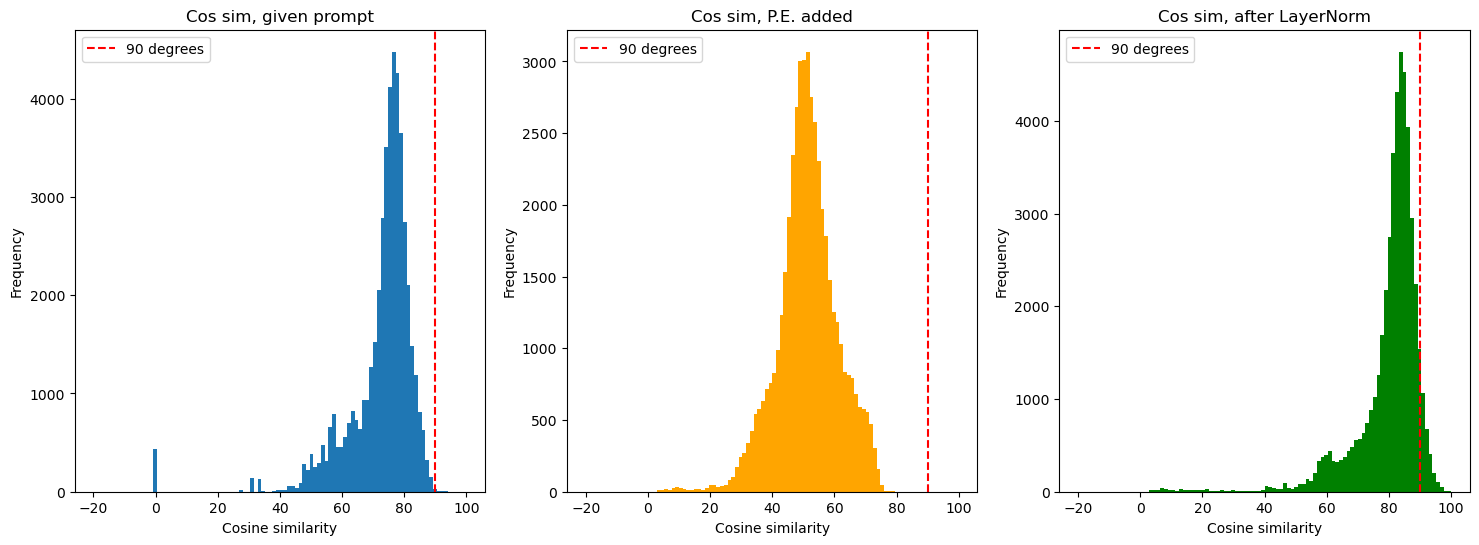

1.7140172741242818 4.0568398130791525 1.2647132745810918
3.100862447704588 5.1742318740912845 2.9053730496338437
R factor before PE: 0.553
R factor after PE: 0.784
R factor after LayerNorm: 0.435


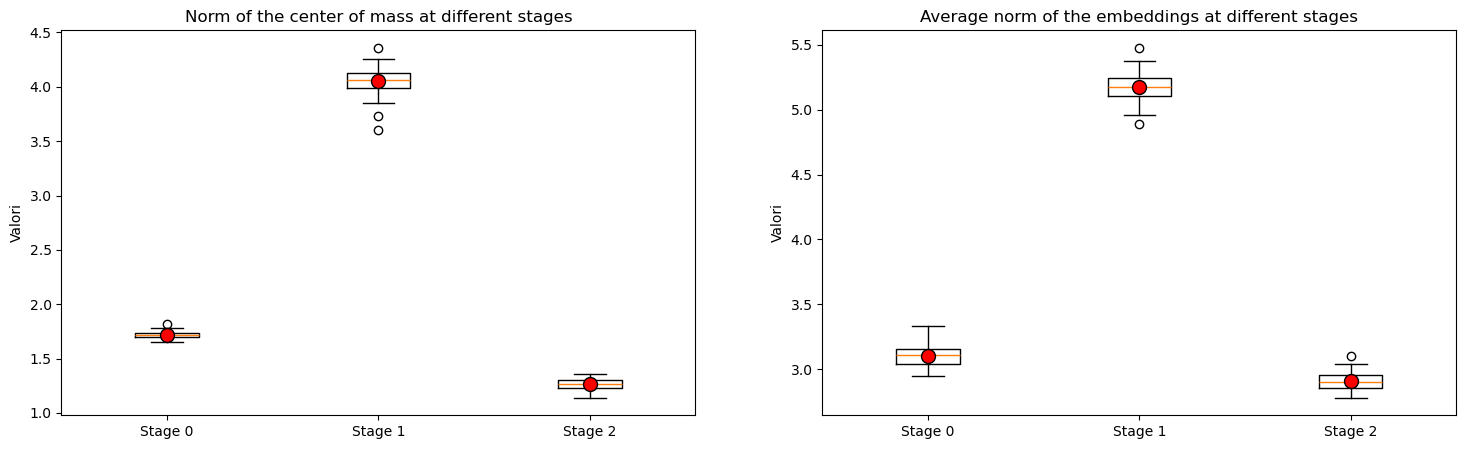

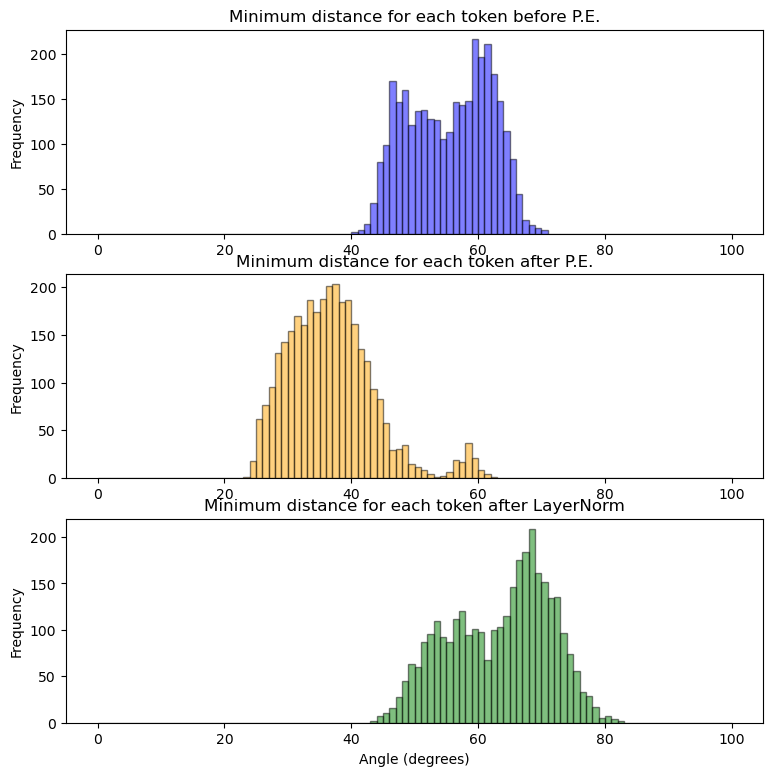

In [58]:
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

ax[0].hist(np.arccos(cosine_similarities_only_buffer)*180/np.pi, bins=100, range = (-20,100))
ax[0].axvline(90, color='red', linestyle='--', label='90 degrees')
ax[0].set_title("Cos sim, given prompt")
ax[0].set_xlabel("Cosine similarity")
ax[0].legend()
ax[0].set_ylabel("Frequency")

ax[1].hist(np.arccos(cosine_similarities_with_PE)*180/np.pi, bins=100, range = (-20,100), color = "orange")
ax[1].axvline(90, color='red', linestyle='--', label='90 degrees')
ax[1].set_title("Cos sim, P.E. added")
ax[1].set_xlabel("Cosine similarity")
ax[1].legend()
ax[1].set_ylabel("Frequency")

ax[2].hist(np.arccos(cosine_similarities_with_LN)*180/np.pi, bins=100, range = (-20,100), color = "green")
ax[2].axvline(90, color='red', linestyle='--', label='90 degrees')
ax[2].set_title("Cos sim, after LayerNorm")
ax[2].set_xlabel("Cosine similarity")
ax[2].set_ylabel("Frequency")
ax[2].legend()

plt.show()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))

data = [norm_CM_before_PE, norm_CM_after_PE, norm_CM_after_ln]
labels = ['Stage 0', 'Stage 1', 'Stage 2']
ax1.boxplot(x=data, showmeans=True,
            meanprops={
                "marker": "o",
                "markerfacecolor": "red",
                "markeredgecolor": "black",
                "markersize": 10
            })
ax1.set_xticks(ticks=range(1,4), labels=labels)
ax1.set_title("Norm of the center of mass at different stages")
ax1.set_ylabel("Valori")

data = [mean_norm_before_PE, mean_norm_after_PE, mean_norm_after_ln]
labels = ['Stage 0', 'Stage 1', 'Stage 2']
ax2.boxplot(x=data, showmeans=True,
            meanprops={
                "marker": "o",
                "markerfacecolor": "red",
                "markeredgecolor": "black",
                "markersize": 10
            })
ax2.set_xticks(ticks=range(1,4), labels=labels)
ax2.set_title("Average norm of the embeddings at different stages")
ax2.set_ylabel("Valori")

print(np.mean(norm_CM_before_PE), np.mean(norm_CM_after_PE), np.mean(norm_CM_after_ln))
print(np.mean(mean_norm_before_PE), np.mean(mean_norm_after_PE), np.mean(mean_norm_after_ln))

print(f"R factor before PE: { np.mean(norm_CM_before_PE) / np.mean(mean_norm_before_PE):.3f}")
print(f"R factor after PE: { np.mean(norm_CM_after_PE) / np.mean(mean_norm_after_PE):.3f}")
print(f"R factor after LayerNorm: { np.mean(norm_CM_after_ln) / np.mean(mean_norm_after_ln):.3f}")


plt.show()

fig, ax = plt.subplots(3,1,figsize=(9, 9))
ax[0].hist(np.arccos(angles_before_PE)*180/np.pi, color='blue', alpha=0.5, edgecolor='black', bins = 100, range=(0, 100))
ax[0].set_title("Minimum distance for each token before P.E.")

ax[0].set_ylabel("Frequency")
ax[1].hist(np.arccos(angles_after_PE)*180/np.pi, color='orange', alpha=0.5, edgecolor='black', bins = 100, range=(0, 100))
ax[1].set_title("Minimum distance for each token after P.E.")

ax[1].set_ylabel("Frequency")
ax[2].hist(np.arccos(angles_after_ln)*180/np.pi, color='green', alpha=0.5, edgecolor='black', bins = 100, range=(0, 100))
ax[2].set_title("Minimum distance for each token after LayerNorm")
ax[2].set_xlabel("Angle (degrees)")
ax[2].set_ylabel("Frequency")
plt.show()

It seems like they are getting closer ?

Come posso studiare una distribuzione di punti in uno spazio multi-dimensionale?

Il centro di massa è un buon punto di partenza. Se il centro di massa è compatibile con l'origine, i punti sono distribuiti omogeneamente attorno all'origine. Al contrario, la questione non è così semplice poiché i punti potrebbero essere distribuiti omogeneamente attorno ad una sfera il cui centro è spostato. 